In [100]:
import pandas as pd
import numpy as np
import os
import numpy
import matplotlib.pyplot as plt
import SimpleITK
import itertools
import sys
import torch
from torchvision import transforms
from PIL import Image
from matplotlib import cm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from pathlib import Path

SOURCE_PATH = Path(os.getcwd()) / 'src'

if SOURCE_PATH not in sys.path:
    sys.path.append(SOURCE_PATH)

from src.extraction import (
    get_images_lists_from_path,
    get_images_lists_from_more_paths
)

from src.plots import (
    plot_observation
)

from src.loading import (
    load_images_from_paths
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
type_to_use = 'flair'
seg_path = Path(os.getcwd()) / 'data_extracted' / 'seg'
input_path = Path(os.getcwd()) / 'data_extracted' / type_to_use

In [102]:
images, segs = load_images_from_paths(input_path, seg_path)

# images_tensors = pad_sequence([torch.tensor(x) for x in images], batch_first=True)
# seg_tensors = pad_sequence([torch.tensor(x) for x in segs], batch_first=True)
# images_dataloader = DataLoader(images_tensors, batch_size=16, shuffle=True)

In [103]:
# modelname = 'weights.pt'
#modelname = 'flair_model1.pt'
modelname = 'flair_model1_noshuffle.pt'
model = torch.load(Path(os.getcwd()) / 'models' / modelname)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [104]:
#input_image = Image.open(str(Path(os.getcwd()) / 'data_extracted' / 't2' / 't2_0.jpeg'))

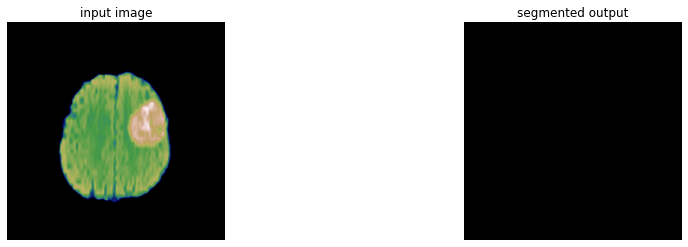

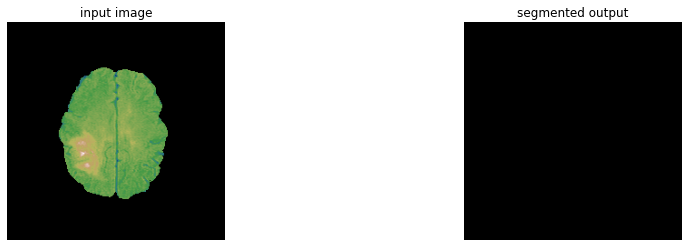

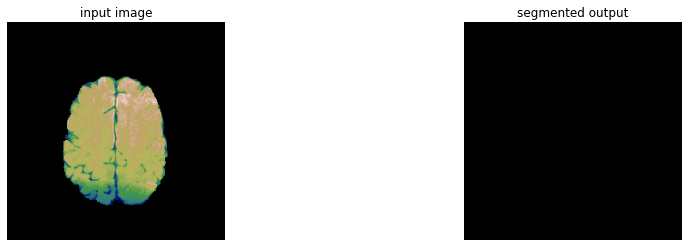

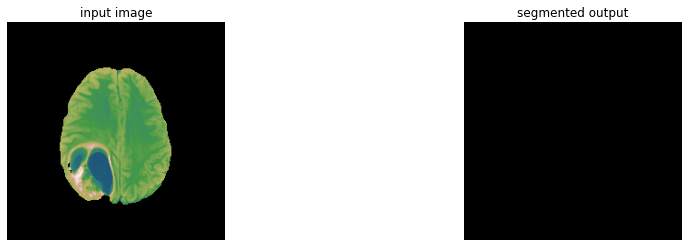

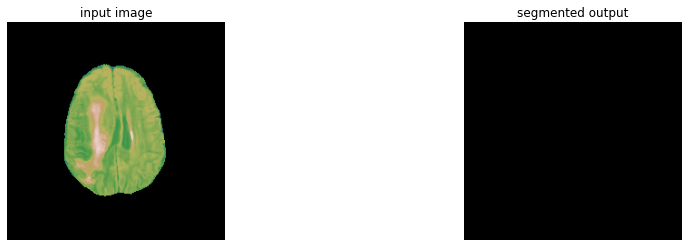

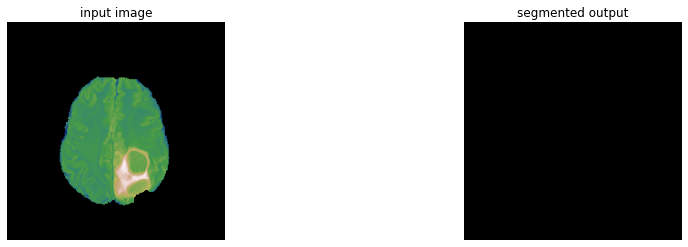

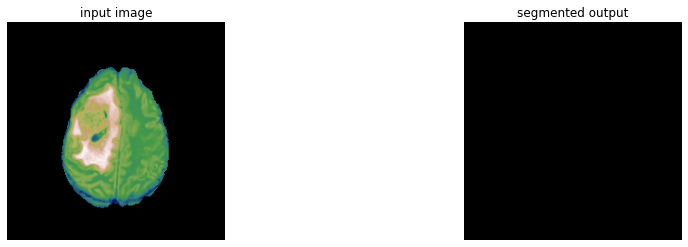

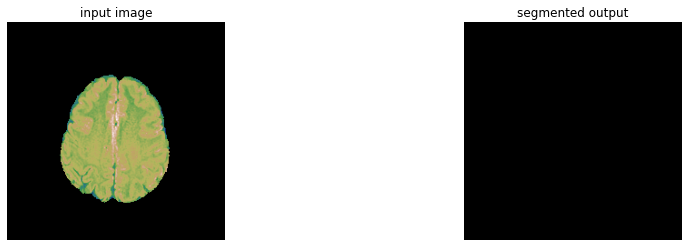

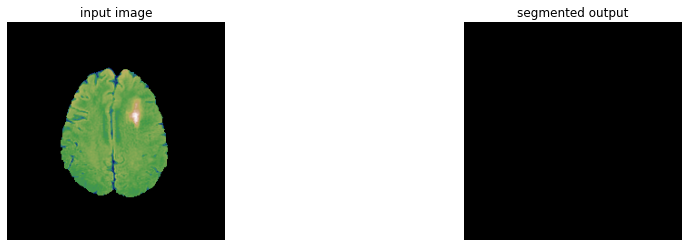

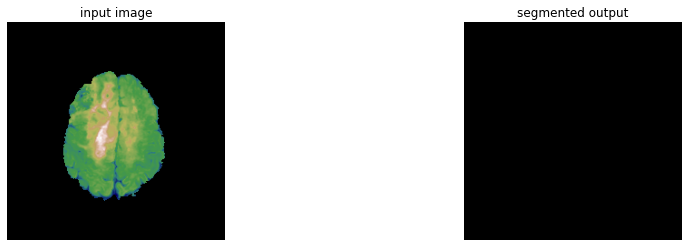

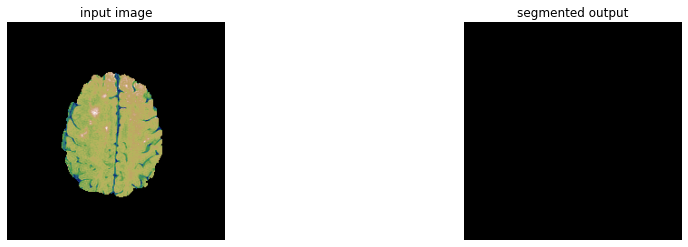

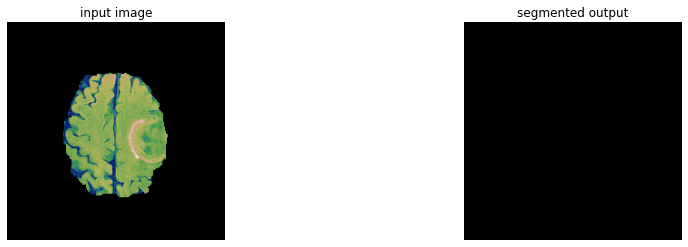

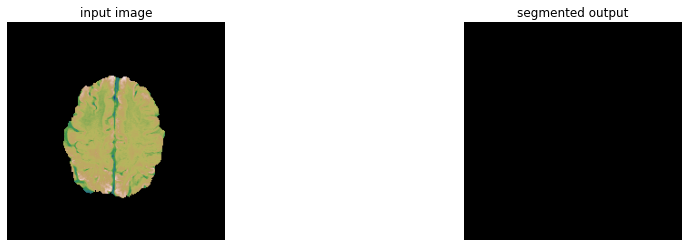

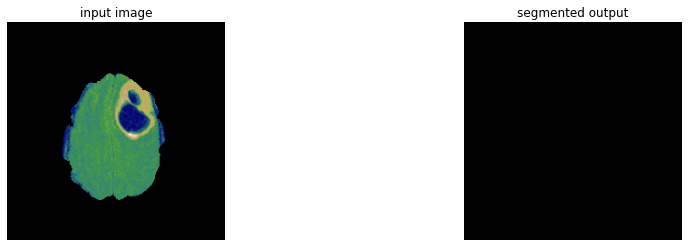

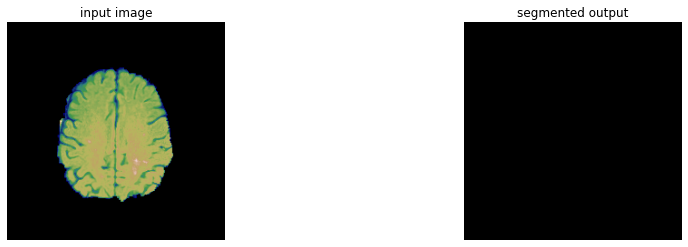

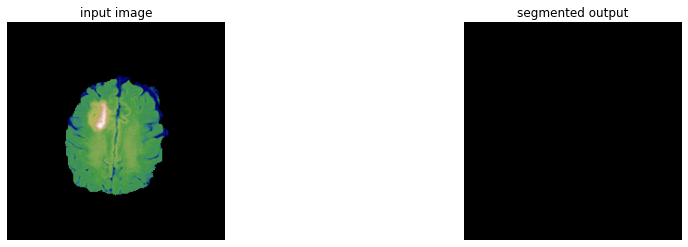

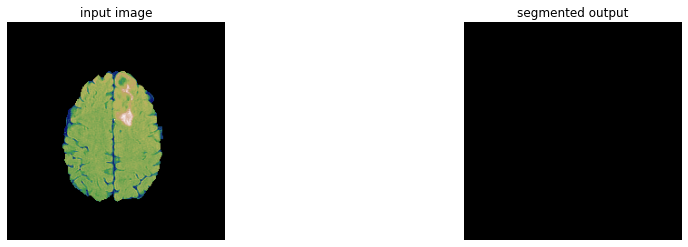

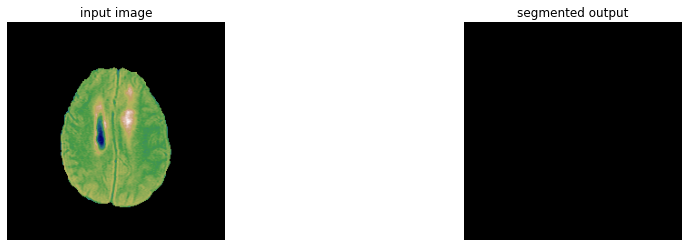

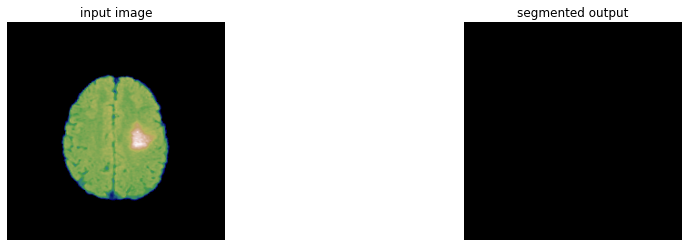

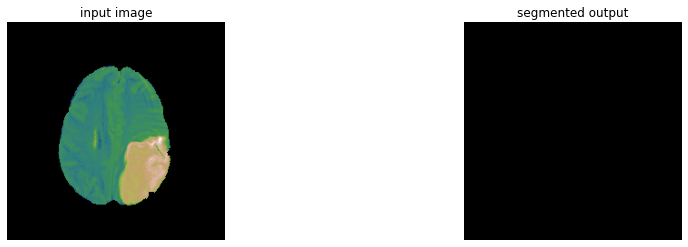

In [105]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    ])

indexes_predict = np.arange(0, 20)

for i in indexes_predict:
    input_image = Image.fromarray(images[i])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) 

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)

    f, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title('input image')
    ax[0].axis('off')
    ax[0].imshow(input_image)
    ax[1].set_title('segmented output')
    ax[1].axis('off')
    ax[1].imshow(r)
    #plt.savefig("segmented_output.png", bbox_inches='tight')
    plt.show()